In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import math
plt.rcdefaults()
%matplotlib inline

In [2]:
def load_df(basePath):
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [ f for f in listdir(basePath) if isfile(join(basePath,f)) and f.endswith(".csv") ]
    df_list = []
    df = []
    for f in onlyfiles:
        print "processing " + basePath + f
        df1 = pd.read_csv(basePath + f, index_col = "loggingTime",parse_dates=True, infer_datetime_format=True)
        if len(df)==0:
            df = df1
        else:
            df = df.append(df1)            
        #df_list.append(df1)
    #df = pd.concat(df_list)
    #a_df = df[["accelerometerAccelerationX","accelerometerAccelerationY","accelerometerAccelerationZ"]]
    #a_df.plot(figsize=(50,10))
    return df

#Features

In [3]:
def get_windows(df):
    gdf = df.groupby(pd.TimeGrouper('1s',closed='left'))
    groups = [group for group in gdf]
    windows = []
    overlap = 3
    for i in range(overlap-1,len(groups)):
        name = groups[i][0]
        windows.append(pd.concat([x[1] for x in groups[i-overlap+1:i+1]]))
    return windows

In [4]:
def normalize(df):
    df_acc = df[["motionYaw","motionRoll","motionPitch","accelerometerAccelerationX", 
                 "accelerometerAccelerationY", "accelerometerAccelerationZ",
                "gyroRotationX", "gyroRotationY", "gyroRotationZ"]]
    accx = []
    accy = []
    accz = []
    gyx = []
    gyy = []
    gyz = []
    for row in df_acc.values:
        new_point = rotate_xyz(row[:3], row[3:6])
        accx.append(new_point[0])
        accy.append(new_point[1])
        accz.append(new_point[2])
        new_point = rotate_xyz(row[:3], row[6:])
        gyx.append(new_point[0])
        gyy.append(new_point[1])
        gyz.append(new_point[2])
    df.loc[:,"accx"] = pd.Series(data=accx, index=df.index)
    df.loc[:,"accy"] = pd.Series(data=accy, index=df.index)
    df.loc[:,"accz"] = pd.Series(data=accz, index=df.index)
    df.loc[:,"gyx"] = pd.Series(data=gyx, index=df.index)
    df.loc[:,"gyy"] = pd.Series(data=gyy, index=df.index)
    df.loc[:,"gyz"] = pd.Series(data=gyz, index=df.index)
    return df

def rotate_xyz(theta, point):
    point = np.array([point]).T
    point = rotate_x(theta[0], point)
    point = rotate_y(theta[1], point)
    point = rotate_z(theta[2], point)
    point = np.array(point.T)[0]
    return point

def rotate_x(theta, point):
    rx = np.array([[1, 0, 0],[0, math.cos(theta), -math.sin(theta)],[0, math.sin(theta), math.cos(theta)]])
    return np.asmatrix(rx)*np.asmatrix(point)

def rotate_y(theta, point):
    ry = np.array([[math.cos(theta), 0, math.sin(theta)],
                   [0, 1, 0],
                   [-math.sin(theta), 0, math.cos(theta)]])
    return np.asmatrix(ry)*np.asmatrix(point)

def rotate_z(theta, point):
    ry = np.array([[math.cos(theta), -math.sin(theta), 0],
                   [math.sin(theta), math.cos(theta), 0],
                   [0, 0, 1]])
    return np.asmatrix(ry)*np.asmatrix(point)

In [5]:
def extract_features(df_list):
    features_names = ["avg_acc", "max_acc", "min_acc", "avg_gyro", "max_gyro", "min_gyro",
                      "h_acc","v_acc","gyro_f","dist","y"]
    f_map = {}
    for fname in features_names:
        f_map[fname] = []
    N = len(df_list)
    print N
    for i,df in enumerate(df_list):
        print str(i)+",",
        ndf = df[["state"]]
        #df_acc = df[["accelerometerAccelerationX", "accelerometerAccelerationY", "accelerometerAccelerationZ"]]
        ndf.loc[:,"acc"] = pd.Series(data=(df[["accx", "accy", "accz"]]**2).sum(axis=1), index=df.index)
        ndf.loc[:,"h_acc"] = pd.Series(data=(df[["accx", "accy"]]**2).sum(axis=1), index=df.index)
        ndf.loc[:,"v_acc"] = pd.Series(data=(df[["accz"]]**2).sum(axis=1), index=df.index)
        ndf.loc[:,"gyro"] = (df[["gyx", "gyy", "gyz"]]**2).sum(axis=1)    
        ndf.loc[:,"gyro_f"] = zero_crossing(df["gyx"], -0.01, 0.01)
        #acc = df[["accx", "accy", "accz"]]**2).sum(axis=1)
        #h_acc = df[["accx", "accy"]]**2).sum(axis=1)
        #v_acc = df[["accz"]]**2).sum(axis=1)
        
        agg = ndf.mean()
        if np.isnan(agg["acc"]):
            continue
        f_map["avg_acc"].append(agg["acc"])
        f_map["avg_gyro"].append(agg["gyro"])
        
        f_map["h_acc"].append(agg["h_acc"])
        f_map["v_acc"].append(agg["v_acc"])        
        f_map["gyro_f"].append(agg["gyro_f"])
        f_map["dist"].append(df["accx"].sum()**2+df["accy"].sum()**2+df["accz"].sum()**2)

        agg = ndf.max()
        f_map["max_acc"].append(agg["acc"])   
        f_map["max_gyro"].append(agg["gyro"])
        f_map["y"].append(agg["state"]+0.1)

        agg = ndf.min()
        f_map["min_acc"].append(agg["acc"])    
        f_map["min_gyro"].append(agg["gyro"])
    return pd.DataFrame(data=f_map)

In [6]:
def plot_map(f_map):
    f, ax = plt.subplots(len(f_map), sharex=True,figsize=(10,len(f_map)*3))
    for i,f in enumerate(f_map):
        ax[i].plot(f_map[f])
        ax[i].set_title(f)

## classification

In [7]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import svm
import sklearn
import pickle

def split(df):
    train_ratio = 0.5
    N = len(df)
    cols = [x for x in df.columns.get_values() if x!="y"]
    X = df[cols].values
    Y = df["y"].values
    X_train = X[:int(train_ratio*N)]
    X_test = X[int(train_ratio*N):]
    Y_train = Y[:int(train_ratio*N)]    
    Y_test = Y[int(train_ratio*N):]
    return [X, Y, X_train, Y_train, X_test, Y_test]
    
def scale(X):
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pickle.dump(scaler, open("scaler.pickle", 'w'))
    return scaler, X_scaled

def train(X,Y):
    clf = linear_model.LogisticRegression(C=1e5)
    #clf = svm.SVC(kernel='poly',degree=3)
    clf.fit(X, Y)
    pickle.dump(clf, open("model.pickle", 'w'))
    return clf
    
def predict(scaler, clf, X):
    X_test_scaled = scaler.transform(X)
    return clf.predict(X_test_scaled)
    #return sklearn.cross_validation.cross_val_predict(clf, X_scaled, Y, cv=5)

In [8]:
##clustering

In [9]:
def plot_svd(df):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=2)
    X_svd = svd.fit_transform(df)
    return X_svd

In [10]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
def anomaly_detect(df):
    outliers_fraction = 0.005
    clf = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1)
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(df)
    clf.fit(X)
    pickle.dump(clf, open("ad.pickle", 'w'))
    return clf

In [11]:
def zero_crossing(x, lt, ht):
    out = []
    cur_state = 0    
    prev_state = 0
    for i in x:
        if i > ht:
            cur_state = 1
        elif i < lt:
            cur_state = 0
        else:
            cur_state = prev_state
        if cur_state==prev_state:
            out.append(0)
        else:
            out.append(1)
        prev_state = cur_state
    return out

In [12]:
basePath = "/Users/karthik/Documents/workspace/sequoia-ml/data/"
columns = ["motionYaw","motionRoll","motionPitch", "accelerometerAccelerationX", "accelerometerAccelerationY", 
           "accelerometerAccelerationZ", "gyroRotationX", "gyroRotationY", "gyroRotationZ",
          "state"]
df = load_df(basePath)
df = df[columns]
normalize(df)
df_windowed = get_windows(df)

processing /Users/karthik/Documents/workspace/sequoia-ml/data/2015-08-29_22-32-22.csv
processing /Users/karthik/Documents/workspace/sequoia-ml/data/2015-08-29_22-36-15.csv
processing /Users/karthik/Documents/workspace/sequoia-ml/data/2015-08-29_22-39-54.csv


In [13]:
f_df = extract_features(df_windowed)

f_df = f_df[f_df["y"]<4.1]
f_df.loc[(f_df["y"]==2.1) & (f_df['max_acc']<20), 'y'] = 0.1

[X, Y, X_train, Y_train, X_test, Y_test] = split(f_df)

/Users/karthik/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/karthik/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


527
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

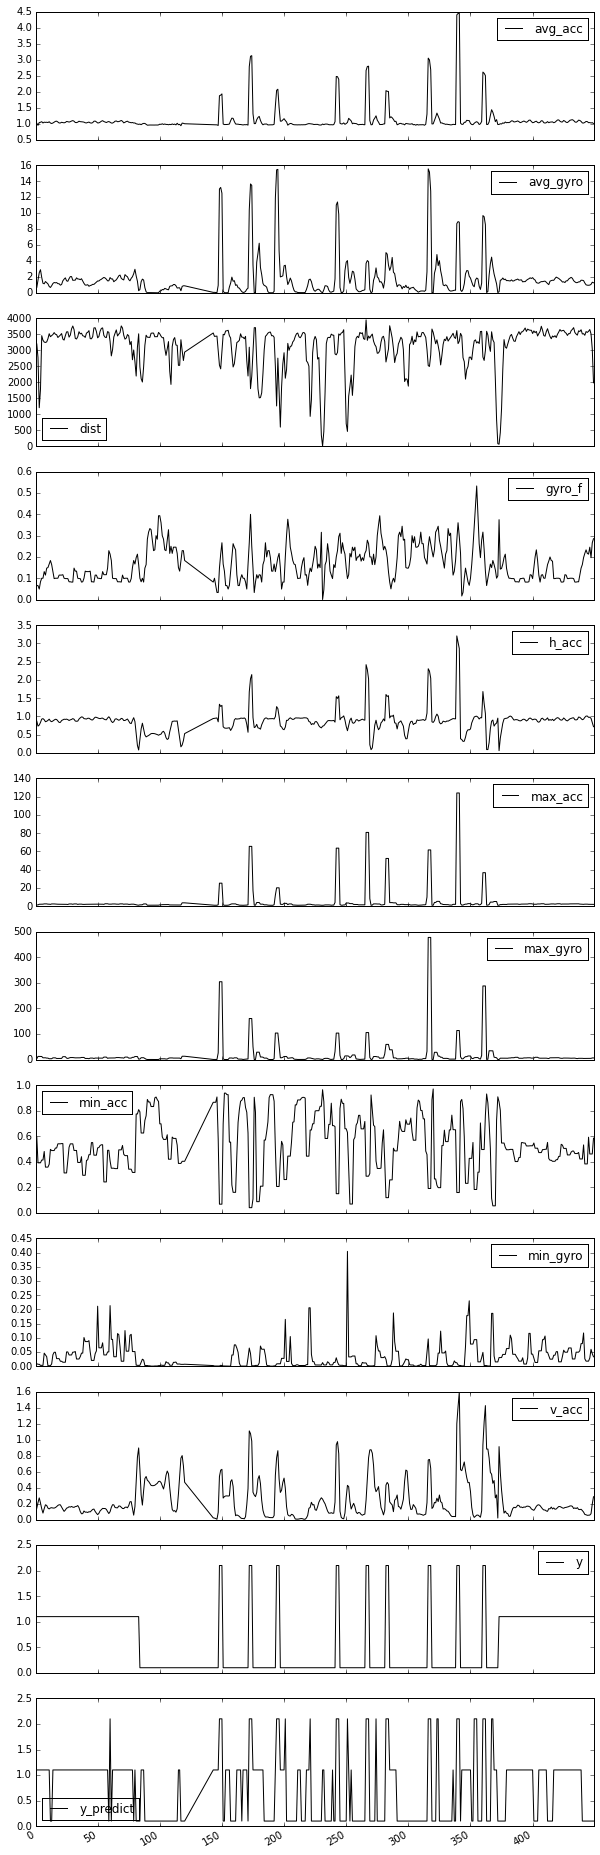

In [14]:
scaler, X_train_scaled = scale(X_train)
X_scaled = scaler.transform(X)

df_viz = f_df.copy()

mode = "AD1"
if mode!="AD":
    clf = train(X_scaled, Y)
    y_predict = predict(scaler, clf, X_scaled)
    df_viz.loc[:,'y_predict'] = pd.Series(data=y_predict, index=f_df.index)
else:
    ad_clf = anomaly_detect(X_scaled)
    ad_score = ad_clf.decision_function(X_scaled).ravel()
    ad_predict = ad_clf.predict(X_scaled)
    df_viz.loc[:,'ad_score'] = pd.Series(data=ad_score, index=f_df.index)
    df_viz.loc[:,'ad_predict'] = pd.Series(data=ad_predict, index=f_df.index)
tmp1 = df_viz.plot(subplots=True, figsize=(10,df_viz.columns.size*3))

In [ ]:
##outlier and novelty detection

In [ ]:
print len(clf.decision_function(X_scaled).ravel())
print len(y_predict)
print len(f_df)

In [ ]:
svd = plot_svd(f_df)
fig = plt.figure(figsize=(20,20))
plt.scatter(svd[:,0],svd[:,1])

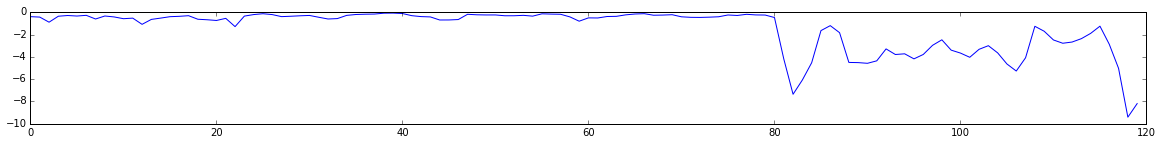

In [48]:
plt.figure(figsize=(20,2))
plt.plot(clf.predict_log_proba(X_scaled)[:120,1])

In [40]:
clf.classes_

array([ 0.1,  1.1,  2.1])

In [ ]:
for x in df.values:
    print x
    break

In [ ]:
np.array([[1, 2, 3]]).shape

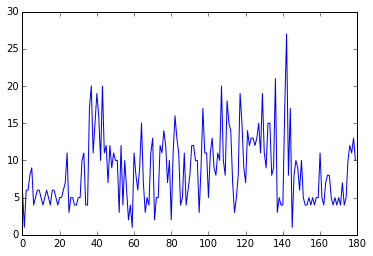

In [72]:
ndf = normalize(df)
#f["gyx"].plot(subplots=True, figsize=(100,5))
a= ndf["gyx"]
b = np.array(zero_crossing(a, -0.001, 0.001))
n = len(ndf["gyx"])
f = []
for i in range(0,n,50):
    f.append(np.sum(b[i:i+50]))
plt.plot(f)

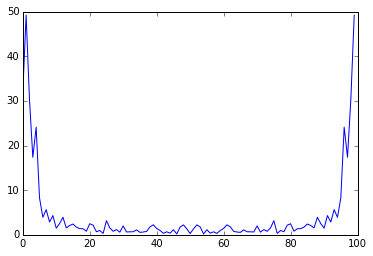

In [75]:
n = len(df["gyx"])
f = []
for i in range(0,n,300):
    a = np.fft.fft(df["gyx"][i:i+100])
    #f.append(np.argmax(a))
    plt.plot(np.abs(a))
    break


In [57]:
n

8970

In [15]:
len(df_windowed)

527